<a href="https://colab.research.google.com/github/carolynw898/STAT946Proj/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import torch

n_embd = 512
timesteps = 1000
batch_size = 256
learning_rate = 1e-4
num_epochs = 5
blockSize = 32
testBlockSize = 400
numVars = 3
numYs = 1
numPoints = 250
target = 'Skeleton'
const_range = [-2.1, 2.1]
trainRange = [-3.0, 3.0]
decimals = 8
addVars = False
maxNumFiles = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
dataDir = "/content/drive/MyDrive/Colab/STAT946_proj/data"
dataFolder = "3_var_dataset"

In [25]:
from torch.utils.data import DataLoader
import numpy as np
import glob
from utils import processDataFiles, CharDataset, tokenize_equation
import random
import json

path = '{}/{}/Train/*.json'.format(dataDir, dataFolder)
files = glob.glob(path)[:maxNumFiles]
text = processDataFiles(files)
text = text.split('\n') # convert the raw text to a set of examples
# skeletons = []
skeletons = [json.loads(item)['Skeleton'] for item in text if item.strip()]
all_tokens = set()
for eq in skeletons:
    all_tokens.update(tokenize_equation(eq))
integers = {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}
all_tokens.update(integers)  # add all integers to the token set
tokens = sorted(list(all_tokens) + ['_', 'T', '<', '>', ':'])  # special tokens
trainText = text[:-1] if len(text[-1]) == 0 else text
random.shuffle(trainText) # shuffle the dataset, it's important specailly for the combined number of variables experiment

In [26]:
train_dataset = CharDataset(trainText, blockSize, tokens=tokens, numVars=numVars,
                        numYs=numYs, numPoints=numPoints, target=target, addVars=addVars,
                        const_range=const_range, xRange=trainRange, decimals=decimals)

idx = np.random.randint(train_dataset.__len__())
inputs, outputs, points, variables = train_dataset.__getitem__(idx)
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\noutputs:{}\nvariables:{}'.format(idx,outputs,variables))

data has 498101 examples, 30 unique.
id:237151
outputs:C*exp(C*x1)+C>_____________________
variables:1


In [27]:
path = '{}/{}/Test/*.json'.format(dataDir,dataFolder)
files = glob.glob(path)
textTest = processDataFiles([files[0]])
textTest = textTest.split('\n') # convert the raw text to a set of examples
test_dataset = CharDataset(textTest, blockSize, tokens=tokens, numVars=numVars,
                        numYs=numYs, numPoints=numPoints, target=target, addVars=addVars,
                        const_range=const_range, xRange=trainRange, decimals=decimals)

# print a random sample
idx = np.random.randint(test_dataset.__len__())
inputs, outputs, points, variables = test_dataset.__getitem__(idx)
print(points.min(), points.max())
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\noutputs:{}\nvariables:{}'.format(idx,outputs,variables))

test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=False,
        num_workers=2
    )

data has 926 examples, 30 unique.
tensor(-11.8914) tensor(13.0782)
id:449
outputs:C*cos(C*x2)/C*log(C*x1)+C>____________
variables:2


In [28]:
import torch
import json
from scipy.optimize import minimize
from math import log
import math
from utils import relativeErr, lossFunc
import numpy as np

SAFE_GLOBALS = {
    'sin': math.sin,
    'cos': math.cos,
    'tan': math.tan,
    'log': math.log,
    'exp': math.exp,
    'sqrt': math.sqrt,
    'abs': abs,
    'pow': pow,
    '__builtins__': {}
}

@torch.no_grad()
def test_model(model, test_loader, textTest, train_dataset, device):
    results = {"target": [], "target_skeleton": [], "predicted_skeleton": [], "predicted": [], "error": []}
    for batch_idx, (_, tokens, points, variables) in enumerate(test_loader):
        points = points.to(device)
        tokens = tokens.to(device)
        variables = variables.to(device)
        B = points.shape[0]
        predicted_skeletons = model.sample(points, variables, train_dataset, B, guidance_scale=0.9)

        for i in range(B):
            t = json.loads(textTest[batch_idx * test_loader.batch_size + i])
            eq = t["EQ"]

            eq_skeleton = ''.join([train_dataset.itos[int(i)] for i in tokens[0]])
            eq_skeleton = eq_skeleton.strip(train_dataset.paddingToken).split('>')
            eq_skeleton = eq_skeleton[0] #if len(eq[0])>=1 else eq[1]
            eq_skeleton = eq_skeleton.strip('<').strip(">")

            # Predicted
            predicted_skeleton = predicted_skeletons[i]
            predicted = predicted_skeleton



            # Fit constants
            c = [1.0 for i,x in enumerate(predicted) if x=='C'] # initialize coefficients as 1
            # c[-1] = 0 # initialize the constant as zero
            b = [(-2,2) for i,x in enumerate(predicted) if x=='C']  # bounds on variables
            try:
                if len(c) != 0:
                    # This is the bottleneck in our algorithm
                    # for easier comparison, we are using minimize package
                    cHat = minimize(lossFunc, c, #bounds=b,
                                args=(predicted, t['X'], t['Y']))

                    predicted = predicted.replace('C','{}').format(*cHat.x)
            except ValueError:
                raise 'Err: Wrong Equation {}'.format(predicted)
            except Exception as e:
                raise 'Err: Wrong Equation {}, Err: {}'.format(predicted, e)

            Ys = [] #t['YT']
            Yhats = []
            for xs in t['XT']:
                try:
                    eqTmp = eq + '' # copy eq
                    eqTmp = eqTmp.replace(' ','')
                    eqTmp = eqTmp.replace('\n','')
                    for i,x in enumerate(xs):
                        # replace xi with the value in the eq
                        eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                        if ',' in eqTmp:
                             raise ValueError('There is a , in the equation!')
                    YEval = eval(eqTmp, SAFE_GLOBALS)
                    YEval = 0 if np.isnan(YEval) else YEval
                    YEval = 100 if np.isinf(YEval) else YEval
                except:
                    #print('TA: For some reason, we used the default value. Eq:{}'.format(eqTmp))
                    #print(i)
                    #raise
                    continue # if there is any point in the target equation that has any problem, ignore it
                    YEval = 100 #TODO: Maybe I have to punish the model for each wrong template not for each point
                Ys.append(YEval)
                try:
                    eqTmp = predicted + '' # copy eq
                    eqTmp = eqTmp.replace(' ','')
                    eqTmp = eqTmp.replace('\n','')
                    for i,x in enumerate(xs):
                        # replace xi with the value in the eq
                        eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                        if ',' in eqTmp:
                            assert 'There is a , in the equation!'
                    Yhat = eval(eqTmp, SAFE_GLOBALS)
                    Yhat = 0 if np.isnan(Yhat) else Yhat
                    Yhat = 100 if np.isinf(Yhat) else Yhat
                except:
                    #print('PR: For some reason, we used the default value. Eq:{}'.format(eqTmp))
                    Yhat = 100
                Yhats.append(Yhat)
            err = relativeErr(Ys,Yhats, info=True)

            if type(err) is np.complex128 or type(err) is complex: # replace np.complex with complex
                err = abs(err.real)

            best_err = 1000000
            best_pred = 'C'
            if err < best_err:
                best_err = err
                best_pred = predicted

            print(f'\nTarget: {eq}')
            print(f'Predicted: {best_pred}')
            print('Err:{}'.format(best_err))
            print('-'*10)

            # Compute error and store results
            err = relativeErr(Ys, Yhats, info=True)
            results["target"].append(eq)
            results["target_skeleton"].append(eq_skeleton)
            results["predicted_skeleton"].append(predicted_skeleton)
            results["predicted"].append(best_pred)
            results["error"].append(best_err)

    return results


In [29]:
import matplotlib.pyplot as plt

def plot_and_save_results(resultDict, fName, pconf, titleTemplate, textTest, modelKey='DiffuSym'):
    if isinstance(resultDict, dict):
        num_eqns = len(resultDict[fName][modelKey]['err'])
        num_vars = pconf.numberofVars
        title = titleTemplate.format(num_eqns, num_vars)

        models = list(key for key in resultDict[fName].keys() if len(resultDict[fName][key]['err'])==num_eqns)
        lists_of_error_scores = [resultDict[fName][key]['err'] for key in models if len(resultDict[fName][key]['err'])==num_eqns]
        linestyles = ["-","dashdot","dotted","--"]

        eps = 0.00001
        y, x, _ = plt.hist([np.log([max(min(x+eps, 1e5),1e-5) for x in e]) for e in lists_of_error_scores],
                        label=models,
                        cumulative=True,
                        histtype="step",
                        bins=2000,
                        density=True,
                        log=False)
        y = np.expand_dims(y,0)
        plt.figure(figsize=(15, 10))

        for idx, m in enumerate(models):
            plt.plot(x[:-1],
                y[idx] * 100,
                linestyle=linestyles[idx],
                label=m)

        plt.legend(loc="upper left")
        plt.title(title)
        plt.xlabel("Log of Relative Mean Square Error")
        plt.ylabel("Normalized Cumulative Frequency")

        name = '{}.png'.format(fName.split('.txt')[0])
        plt.savefig(name)

        with open(fName, 'w', encoding="utf-8") as o:
            for i in range(num_eqns):
                err = resultDict[fName][modelKey]['err'][i]
                eq = resultDict[fName][modelKey]['trg'][i]
                predicted = resultDict[fName][modelKey]['prd'][i]
                print('Test Case {}.'.format(i))
                print('Target:{}\nSkeleton:{}'.format(eq, predicted))
                print('Err:{}'.format(err))
                print('') # just an empty line


                o.write('Test Case {}/{}.\n'.format(i,len(textTest)-1))

                o.write('{}\n'.format(eq))
                o.write('{}:\n'.format(modelKey))
                o.write('{}\n'.format(predicted))

                o.write('{}\n{}\n\n'.format(
                                        predicted,
                                        err
                                        ))

                print('Avg Err:{}'.format(np.mean(resultDict[fName][modelKey]['err'])))

def run_and_plot(model, fName, test_loader, textTest, train_dataset, device, pconf=None):
    """
    Run test_model and format results for plot_and_save_results, ensuring one figure.
    """

    results = test_model(model, test_loader, textTest, train_dataset, device)

    modelKey = 'DiffuSym'
    resultDict = {
        fName: {
            modelKey: {
                'err': results['error'],
                'trg': results['target'],
                'prd': results['predicted']
            }
        }
    }

    plt.figure(figsize=(15, 10))
    titleTemplate = "{} equations of {} variables - Benchmark"
    plot_and_save_results(resultDict, fName, pconf, titleTemplate, textTest, modelKey=modelKey)
    plt.close()


Target: -1.5982388017817581*x1*x2+-2.044318899637824*x2+-1.7746907028515462*exp(0.7039673314731902*x1)*-0.8668809182829045*exp(0.3777536736420375*x2)+-2.0127950458697312
Predicted: -7.177450827326768e-05*x2**8.545069333821393+0.014201795919532202
Err:3.8928600189588685
----------

Target: -0.8560034217937049*cos(-0.9890810824569372*x3+-0.29641571396472033)+-1.5646829023003912
Predicted: 1.0*sin(1.0*x3)1.0)
Err:396.0030878765492
----------

Target: 1.7016581024952169*x1*0.23727959985542935*log(0.36487304775466267*x2+0.03292925562520255)+0.8705746155666412
Predicted: 1.0*sin(1.0*x2)1.0)
Err:579.7979847793695
----------

Target: 0.5092136638151619*cos(-1.4746099495487288*x3+0.3151001472880224)**3+-1.9812894758620072
Predicted: 1.0*sin(1.0*x3)1.0)
Err:262.31473439326055
----------

Target: -1.9634546414883929*x1+1.372145030809131*x2+0.6300532975162816*x3+-0.15792781214722296
Predicted: -0.2505527900062296*x1**1.9456044873599452+-0.1455297645987092
Err:0.2370538118074365
----------

Target

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.012303306578191*x1+-0.8647466203839498*x2+-1.912398186811464
Predicted: 1.0*sin(1.0*x2)1.0)
Err:83.31815075339534
----------

Target: 0.42097783877287487*cos(-0.3684045576102637*x1+1.1343597011517619)+-1.9269705344660948
Predicted: 1.0*sin(1.0*x1)1.0)
Err:241.78893754627876
----------

Target: -1.2937220889705878*exp(-1.0547036217698647*x2)*1.9974900707201475*log(-1.18650556984315*x1+-1.51429972108776)**3+-2.0173994064062337
Predicted: 0.006313152619794627*x2**4+-1.7419364067070704
Err:21.3830339584896
----------

Target: 1.5211095768632332*log(-0.24051105212034263*x1)+0.9642465300694201*log(-0.010708434795357213*x2)+1.2787687063427131
Predicted: 1.0*sin(1.0*x2)1.01.0
Err:486.11566586226303
----------

Target: 0.3323086241207771*log(-0.01686432719103692*x1+0.8941643431843458*x2+0.5264124235644441)+-1.5638289781854844
Predicted: 1.0*sin(1.0*x2)1.0)
Err:592.2338608039295
----------

Target: 1.3988692220721548*exp(0.639018293908832*x1)+-0.6198912573459368
Predicted: 1.0*sin(1.

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.0139883253601434*x2+1.4228736557450414*x2/x3+0.8062585018028283/x3+-1.1707745144325998
Predicted: 1.0*x2(1.0*x3)+1.0
Err:103.1395525064764
----------

Target: -0.3456661354663415*log(0.8267764172825274*exp(1.495683187997034*x2))+0.8158768951754878
Predicted: 1.0*sin(1.0*x2)1.0)
Err:188.9461976583787
----------

Target: -1.4709026976663169*x2*x3+-1.1895735429867398*x3**2+1.8995526886406875
Predicted: -0.001125234072152185*x1**4+0.11570320523370979
Err:1.4238890287808281
----------

Target: 1.135408347476047*cos(0.9230722404193523*x1+-1.0924436486905396*x2+0.2725348865921311*sin(-0.8845040840444112*x3))+0.45734709079624025
Predicted: 1.0*sin(1.0*x3)1.0)
Err:440.63106105007273
----------

Target: -1.305090688593706*exp(-0.5785712301964743*x1)+1.2323351159504754
Predicted: 1.0*sin(1.0*x1)1.0)
Err:52.72916732495333
----------

Target: -0.5186068837385807*x1*x3+-1.5565760525696533*x3+0.5165708501197814
Predicted: -0.0003400830924287323*x1**6.396634986941437+0.02053629800683949+0.

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -2.079030676553546*x2+0.7773542153042579*x3+0.9293551036257544
Predicted: 0.018228069071849456*x1**0.11880195807675283+0.700313950646381*0.7003139506463725+-0.29391125621001357
Err:0.4026233100002163
----------

Target: -1.5562712273377246*x1**2+-0.961329488459084*x1+1.7961512490540894*cos(0.24682013301612127*x2)+-1.0091336307212118
Predicted: 0.0015564525892041742*x2**4+0.05383132777391421
Err:1.2987975314832474
----------

Target: 1.8425268707974074*x3/x1+0.1950664510628446/x1+-0.5983321378568482
Predicted: -0.017262139851827122*x1**0.39999216295245293+-0.023552785891470945+-0.023552785891470744+-0.02355278589146994
Err:0.08976357916701465
----------

Target: -1.4908555102613978*x1+-1.9619498959622061*x3+-0.20074613755780435
Predicted: -0.33585185820339664*x1**0.6685991516984142+0.11454723162797321
Err:0.3979424926596098
----------

Target: -1.175365382768889*exp(-1.9606193363623647*x2)+1.1911316433434198
Predicted: 1.0*exp(1.0*x2)+1.0
Err:252.4851147723964
----------

Targe

/content/utils.py:292: RuntimeWarning: overflow encountered in square
  err = ((yHat - y)) ** 2 / np.linalg.norm(y + eps)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
/content/utils.py:292: RuntimeWarning: overflow encountered in square
  err = ((yHat - y)) ** 2 / np.linalg.norm(y + eps)



Target: -2.0784508028846806*x1*x3+-1.3020302281909149
Predicted: -0.030069988916168848*x1**-0.5168429346858757+-0.1590379822917093
Err:1.488740448878469
----------

Target: -1.1638594701420955*sin(-1.5698894624824868*sin(-0.9912849402416184*x3))+0.9078344223570305
Predicted: 1.0*sin(1.0*x3)1.0)
Err:329.6202821847162
----------

Target: -1.271046064156113*sin(-0.9208594144443814*x1)**5+1.6543386352651632
Predicted: 1.0*sin(1.0*x1)1.0)
Err:253.0504412568315
----------

Target: 1.8066755578844824*log(1.5001687311395036*x3/x1)+-1.716739677756813
Predicted: 0.04063792896483157*x1+-0.012161461519620664*x3+-0.12915733172710356+-0.12915733172710347
Err:0.04192729077710475
----------

Target: 0.19209532050468647*x1+0.5761648719193952
Predicted: 1.0*sin(1.0*x1)1.0)
Err:467.1483856205649
----------

Target: -1.6021477622149363*cos(1.4472101816472973*x2)/-1.9203603391506479*log(0.576666122690825*x1)+-0.5775346861786352
Predicted: 1.0*sin(1.0*x2)1.0)
Err:2008.9087733087256
----------

Target: 0.65

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.9888664579849893*x1+0.040788363694159724*x2+0.3559228264326868
Predicted: 1.0*x2(1.0*x2+1.0)
Err:110.9657800797577
----------

Target: 0.6660048937525302*sin(1.7632084687806877*x2+-0.4619416282408513)+-1.6205348333070075
Predicted: 1.0*sin(1.0*x2)1.0)
Err:261.74369268980865
----------

Target: 1.3985525133345438*x2**3+0.2653893385756927*x2**2+1.050328882541625*x2+0.027904827056538295
Predicted: 0.6843172730932456*x2**4+0.005394856883566389
Err:5.058982065284861
----------

Target: 1.4922359785921109*sin(1.822464361427779*x2)+1.109299783075509
Predicted: 1.0*sin(1.0*x2)1.0)
Err:289.0802395290989
----------

Target: 1.7665067910886108*cos(1.9621526394794526*sin(-1.5154046368541403*x2+1.6656165608429463*x3+0.7168262216390429))+1.3624806366172404
Predicted: 1.0*sin(1.0*x3)1.0)
Err:229.23491583865106
----------

Target: -1.3857662306840748*exp(-1.1928461373167485*x2)+0.7750475025401982
Predicted: 1.0137347183643395*x2+-0.624507153506004
Err:7.1970318663758714
----------

Target: 

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.9354737772520543*cos(-1.9524157688483534*x1**2+1.0351795181559873*x1**5+1.4005907603561396*x1**4+0.9808319611155527*x1**3+-1.0579831535053115*x1**2+-0.31020577795358983*x1+1.0942099693897411)+0.4766644442979149
Predicted: 1.0*sin(1.0*x1)1.0)
Err:295.4290088055392
----------

Target: -0.673182493888421*cos(0.5778816486283089*x3+-0.6042970214795331)+0.546261926131729
Predicted: 1.0*sin(1.0*x3)1.0)
Err:461.6619403686704
----------

Target: 1.647659345411427*x1+-0.5404832828000656*x3**5+-1.491062767286623
Predicted: 0.034606739633534146*x1**4+-0.3611325724313614
Err:34.76288687956662
----------

Target: 0.17335392688597695*x1+-0.7333436337624022*x3+1.401316096529019*log(1.854906975680405*x3+-0.09003705096030235)/-0.6919447084077746*sin(-1.5450174931896195*x3+-0.2841251002677232)+-1.8698670417186176
Predicted: 1.0*sin(1.0*x3+1.0)
Err:0.20797690284025375
----------

Target: 0.23308398551335818*x1**4*0.43952759203285785*exp(-0.6064187437399657*x2)+-1.1143370633704028
Predicted: -0

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -0.9734415515634478*exp(1.326363596417366*x1)+-0.41484368245903713
Predicted: 1.0*sin(1.0*x1)1.0)
Err:17.316386208193364
----------

Target: 1.6723983258349064*log(0.285966996311835*exp(-1.7499866430910709*exp(-0.6531905320820479*x1)))+1.9902397783514023
Predicted: 1.0*sin(1.0*x1)1.0)
Err:21.40094883684955
----------

Target: -0.8232520389954956*exp(-0.2848183440618324*x3)+-0.08016902354778876
Predicted: 1.0*sin(1.0*x3)1.0)
Err:230.7410417118827
----------

Target: -1.6676734081718076*log(0.9641142923418369*x1+-1.0666000293176452*x2+-0.7436730958712103)+-1.5620119907158792*sin(1.1724423835805853*x2+1.9870801800659792)**3+0.5345835171104443
Predicted: 1.0*x2(1.0*x2)1.0)
Err:286.7088438972844
----------

Target: 1.9198605361322607*exp(1.7503279994546714*x2)+0.5158541797831306
Predicted: 1.0*x2(1.0*x2)1.01.0
Err:136.3484310263156
----------

Target: -1.764082789614678*x2**5+1.3668810146859598*x2**4+0.5369194156983017*x2**3+0.7210978014941833*x2**2+-2.0506124013248637*x2+-1.403636

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 1.4562318022682277*x1/(-2.0564608824711845*x3+-1.8716735011158943)+-1.769470084845688*x2**2/(0.12643160498533623*x3+-1.96283771320747)+-0.004338676808082642*x2+-0.8293448666202055*cos(-1.2328726183224372*x2+1.741982715064725)+-0.08258219621135554
Predicted: 0.10035557914361566*x2**4.137347194983652+-0.06824080666444393
Err:1.6590521694210605
----------

Target: 1.458498229934786*x1+-1.5116379032328737*x3+-0.5802517658687318*cos(-0.9527611383397876*x1)+-1.2487561817325927
Predicted: 0.18821825903504757*x1**1.1258740846656279+-0.044739262127191225+-0.04473926212719159+-0.044739262127191
Err:0.3310592961070768
----------

Target: 0.21190532786805516*x1*x2**3+-0.12681308086423582*x2+-1.6080797438777008*x3+1.6520611840846477
Predicted: 0.02759330436889121*x1**0.12397689635932105+0.17275087209138926
Err:2.8345095428954363
----------

Target: 0.9907267807001916*exp(0.26212952940565026*x3)+-0.7327219112996675
Predicted: 1.0*sin(1.0*x3)1.0)
Err:293.708732901559
----------

Target: -1.1

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 1.2046452397555538*sin(-1.0438179925980082/x2)+-1.7457676655607242
Predicted: 1.0*sin(1.0*x2)1.0)
Err:261.0894323155406
----------

Target: -1.1785589369023697*x1**3+0.5383399766049886*x1**2+1.7850750059116245*x1+-0.6025536492950454*x1/(-0.013505494473810664*x3+0.7343445219557445)+-1.5082910071975075
Predicted: -0.30894287870256826*x1**4+-1.474070423161221
Err:0.4435542846087601
----------

Target: -1.151460449637558*cos(-1.5361784365118911*x1)/-1.5634137965866408*log(1.7811418045131142*x3)+-1.0063583740071047
Predicted: 1.0*sin(1.0*x3)1.0)
Err:1383.2186494936677
----------

Target: 0.8676608634977772*exp(-1.9781086627389493*x3)+0.193143244824018
Predicted: 1.6613711495209414e-07*x1**12.501180238364025+0.1695124690545889+0.16951246905459583+0.16951246905459896
Err:170.55112559481364
----------

Target: 1.2631454244492386*cos(-0.05033839996173395*x1+0.3606436689228376)+0.34228655174338307
Predicted: 1.0*sin(1.0*x1)1.0)
Err:289.6953632953178
----------

Target: -1.30984966194549

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 1.6288616371145994*log(-0.8756568622131198*x1)+1.755336741247075
Predicted: 1.0*sin(1.0*x1)1.0)
Err:158.17062967919583
----------

Target: 1.384957706842223*x2+1.6366373911329104*exp(0.36431130281021895*x1)+1.0027870695693188*sin(-0.9368558196776051*sin(-0.7765708569955854*x1+-1.6054888743778981))+0.22904804739243367
Predicted: 1.0*x2+1.0*x2)1.0)
Err:55.868042010508475
----------

Target: -0.99795860503145*log(-1.121911100276144*x3)+-0.18082764190772327
Predicted: 1.0*sin(1.0*x3)1.0)
Err:390.0230681599062
----------

Target: -0.8465269817756038*cos(1.6676463236348567*cos(-0.38392244878814563*x1))+-0.8783078942182627
Predicted: 1.0*sin(1.0*x1)1.0)
Err:277.08638863479507
----------

Target: 1.2317621124835112*x1**4+-1.3812365026622317*x1+1.6492212297863436*x2**5+0.7381727909584663
Predicted: 1.8446987476867045*x2**4+0.11727179421192614
Err:66.43526842950126
----------

Target: 1.3553507693451037*x2**2+1.7495202269522854*x3+-1.0170054971298432
Predicted: -0.0026682586729989545*x1

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.6566688808992975*cos(0.15284168894858086*x3+1.3592883114521297)+-0.03135020840769931
Predicted: 1.0*sin(1.0*x3)1.0)
Err:456.611051883471
----------

Target: 0.5851107817245342*x1+-1.2979819549978777*x2+0.009507206029131243/0.16142690985794772*sin(-0.9742505045533649*x2)+-1.8789122113108645
Predicted: 1.0*x2(1.0*x2)1.01.0
Err:75.54174338794252
----------

Target: 2.087889187017717*log(1.047767694055652*exp(0.5629765931495023*x3))+-0.6890819974238083
Predicted: 6.712529531328401e-07*x1+1.1754078416751956*x3+-0.295817633667382+-0.2958176336673819
Err:9.708009522849881e-11
----------

Target: 1.999937836990291*exp(0.015239227184827175*x1)+-0.09138563470049066*log(-0.029638308162709404*x2)+1.6476069899648436*log(0.7668622227021982*log(0.2602246951621381*x1+1.132472607844556))+-0.014168995290078978
Predicted: 1.0*log(1.0*x2)1.0)
Err:570.7424266948351
----------

Target: -1.9448992705457957*exp(1.4560876262363402*x1)+0.051493939462174065
Predicted: 1.0*sin(1.0*x1)1.01.0
Err:41.085

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i

Streaming output truncated to the last 5000 lines.

Avg Err:2703.8510196534767
Test Case 92.
Target:-2.0268843734197923*log(1.455625589027818*cos(-1.9189058947403355*x2+-1.542780384995986))+1.7671706688082418
Skeleton:1.0*sin(1.0*x2)1.0)
Err:175.36601259200225

Avg Err:2703.8510196534767
Test Case 93.
Target:0.47089731057566153*x2+-1.3808562891100027*exp(0.01183462534911417*x2)+-0.7737708011445186
Skeleton:1.0*sin(1.0*x2)1.01.0
Err:164.2334257603363

Avg Err:2703.8510196534767
Test Case 94.
Target:1.4642307150339708*sin(-1.2399985774909745*log(-2.0888574409300444*x1+-0.41476044969032966))+-0.4131722329061802
Skeleton:1.0*sin(1.0*x1)1.0)
Err:521.6358700840049

Avg Err:2703.8510196534767
Test Case 95.
Target:-1.019764320389208*x2**2+0.7295855256593504*x3+1.659226252526258*exp(0.37125022410381625*x3)+-0.4694106444081141
Skeleton:-0.01844659520989026*x1**0.6857178948089746+0.16090934034864396
Err:0.8541758494712935

Avg Err:2703.8510196534767
Test Case 96.
Target:0.28881521554176137*x3+-0.

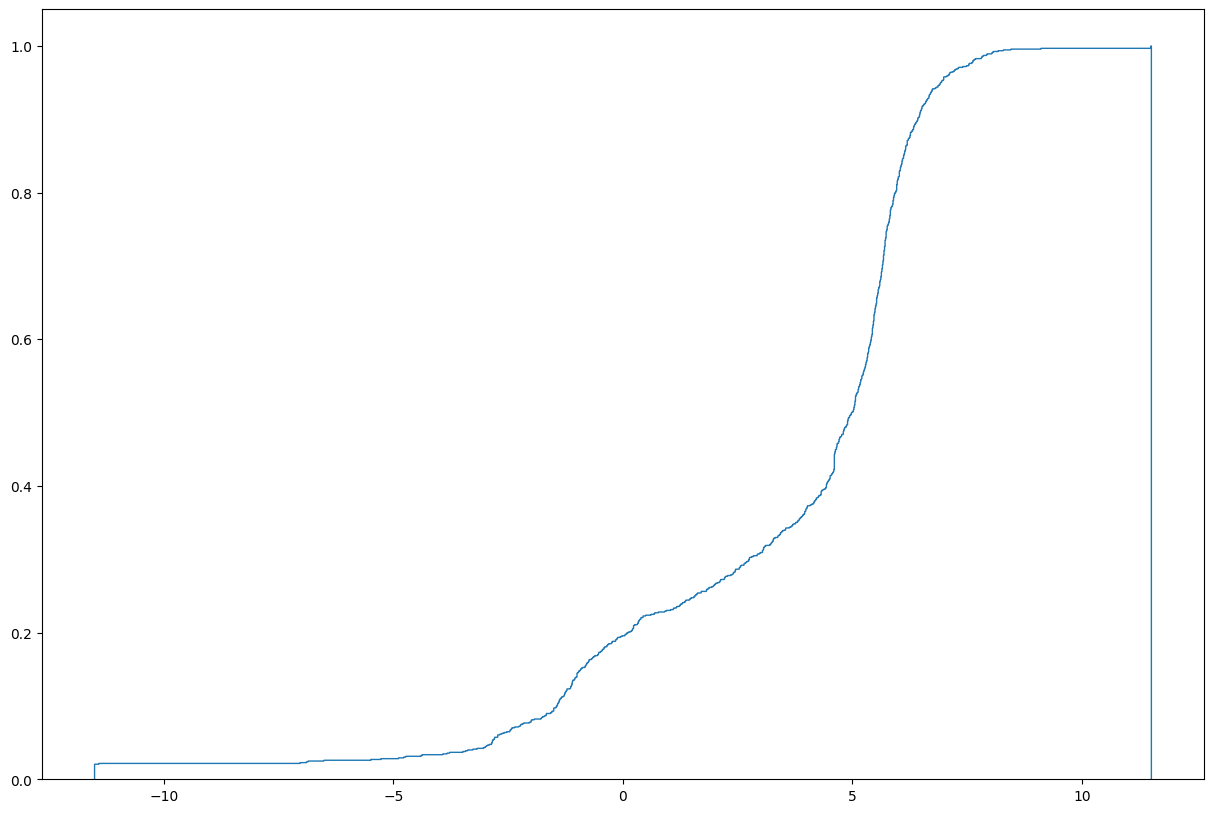

In [30]:
from models import SymbolicGaussianDiffusion, PointNetConfig

pconfig = PointNetConfig(
    embeddingSize=n_embd,
    numberofPoints=numPoints,
    numberofVars=numVars,
    numberofYs=numYs,
)
model = SymbolicGaussianDiffusion(
    tnet_config=pconfig,
    vocab_size=train_dataset.vocab_size,
    max_seq_len=32,
    padding_idx=test_dataset.paddingID,
    max_num_vars=9,
    n_layer=4,
    n_head=4,
    n_embd=n_embd,
    timesteps=timesteps,
    beta_start=0.0001,
    beta_end=0.02,
    set_transformer=True,
).to(device)

model_path = "/content/drive/MyDrive/Colab/STAT946_proj/models/diffusym_cfg/3_var_set_transformer_cfg.pth"
model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
model.eval()
fName="/content/drive/MyDrive/Colab/STAT946_proj/results/diffusym_cfg/ddim_step_1/3_var_set_transformer_cfg.txt"
test_results = run_and_plot(model, fName, test_loader, textTest, train_dataset, device, pconfig)